## **Image Question Answering with Shapes [10pts + 2 extra]**

### **0. Loading resources and installing extra libraries**

In [ ]:
!pip install -q livelossplot
!wget -qnc https://www.cs.rice.edu/~vo9/deep-vislang/ShapesQA_trainset.zip
!unzip -q ShapesQA_trainset.zip
!mv synthetic_shapes_dataset ShapesQA_trainset
!wget -qnc https://www.cs.rice.edu/~vo9/deep-vislang/ShapesQA_valset.zip
!unzip -q ShapesQA_valset.zip
!mv synthetic_shapes_dataset ShapesQA_valset

### **1. Defining a Dataset class**

For this assignment we have created a novel dataset called ShapesQA which is a question answering dataset about images with simple geometric shapes consisting of triangles, circles and squares. The goal is to build a model that can answer questions for this dataset using all the tools at our disposal including for representing images and text.

In [ ]:
import torch, json, random, os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

class ShapesQADataset(Dataset):
    def __init__(self, annotations = "",
                 image_dir = "", vocab = None,
                 transform = None,
                 max_question_len = 20):
        self.annotations = json.load(open(annotations))
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform if transform is not None else transforms.ToTensor()
        self.max_question_len = max_question_len
        # Define a fixed answer mapping (example: 6 colors, 3 shapes, 6 counts = 15 classes)
        self.answer2idx = {"red": 0, "blue": 1, "green": 2, "yellow": 3, "purple": 4, "orange": 5,
                      "circle": 6, "square": 7, "triangle": 8,
                      "0": 9, "1": 10, "2": 11, "3": 12, "4": 13, "5": 14}
        self.idx2answer = {v: k for k, v in self.answer2idx.items()}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = os.path.join(self.image_dir, ann["image"])
        image = Image.open(image_path).convert("RGB")

        # Apply image transformation if specified.
        if self.transform:
            image = self.transform(image)

        question = ann["question"]
        # Apply tokenization to input question if specified.
        if self.vocab:
          tokens = tokenize(question)
          indices = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens]
          if len(indices) < self.max_question_len:
              indices = indices + [self.vocab["<pad>"]] * (self.max_question_len - len(indices))
          else:
              indices = indices[:self.max_question_len]
          question = torch.tensor(indices, dtype=torch.long)
        answer = str(ann["answer"])
        label = self.answer2idx.get(answer, 0)
        label = torch.tensor(label, dtype=torch.long)

        return {"image": image, "question": question, "answer": label, "question_type": ann["question_type"]}

trainset = ShapesQADataset(annotations="ShapesQA_trainset/annotations.json",
                           vocab = None,
                           image_dir="ShapesQA_trainset")
valset = ShapesQADataset(annotations="ShapesQA_valset/annotations.json",
                         vocab = None,
                         image_dir="ShapesQA_valset")

print("Num training images: ", len(trainset))
print("Num validation images: ", len(valset))

Num training images:  1000
Num validation images:  1000


Now let's show a random example from this dataset. Look at many examples by running this code several times to get an idea of the difficulty of the problem.

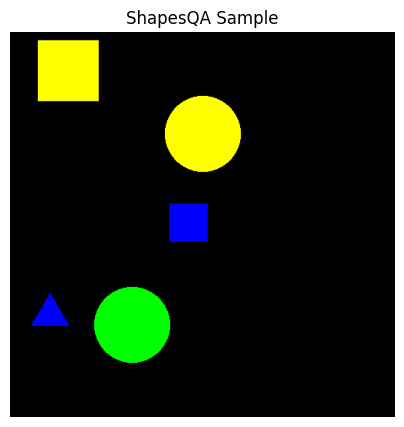

Question: Number of blue circles in the image?
Answer: 0
Question type: count


In [ ]:
def show_sample(sample):
    image_tensor = sample["image"]
    image_np = image_tensor.permute(1, 2, 0).numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(image_np); plt.axis("off")
    plt.title("ShapesQA Sample"); plt.show()
    print("Question:", sample["question"])
    print("Answer:", trainset.idx2answer[sample["answer"].item()])
    print("Question type:", sample["question_type"])

# Display a random sample.
sample_idx = random.randint(0, len(valset) - 1)
sample = valset[sample_idx]
show_sample(sample)

### **2. Defining how batches are loaded**

Here we define how data samples are going to be converted to batch tensors when creating a data loader. Another common step in setting up our problem. In this case, text input needs to be handled such that they can be put in batches despite different questions having different lengths in terms of number of words. A common strategy is to tokenize the input, convert to numerical ids for every word by creating a dictionary (vocabulary) and then using special tokens for words outside the vocabulary and for padding the texts so they all end up with the same length in a batch.

In [ ]:
from collections import Counter

def tokenize(text):
    # A simple tokenizer: lowercase and split on whitespace.
    return text.lower().split()

def build_vocab(questions, min_freq=1):
    """Builds a word2idx dictionary from a list of question strings."""
    counter = Counter()
    for q in questions:
        tokens = tokenize(q)

        # diccionario word vs frecuencia de esa palabra
        counter.update(tokens)
    # Reserve index 0 for <pad> and 1 for <unk>
    vocab = {"<pad>": 0, "<unk>": 1}
    for word, freq in counter.items():

      # me quedo solo con las palabras que aparecen mas de min_freq veces
        if freq >= min_freq:
          # armo el diccionario word vs index
            vocab[word] = len(vocab)
    return vocab

# The collate_fn is a special function in pytorch to indicate how batches
# should be assembled.
def collate_fn(batch):
    images = torch.stack([item["image"] for item in batch], dim=0)
    questions = torch.stack([item["question"] for item in batch], dim=0)
    answers = torch.stack([item["answer"] for item in batch], dim=0)
    # Collect question types as a list of strings.
    question_types = [item["question_type"] for item in batch]
    return {"image": images, "question": questions, "answer": answers, "question_type": question_types}


train_annotations = json.load(open("ShapesQA_trainset/annotations.json"))
all_train_questions = [ann["question"] for ann in train_annotations]

# llamo a la funcion que me arma el word vs index
vocab = build_vocab(all_train_questions, min_freq=1)
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

# Sample code for loading one batch.
trainset = ShapesQADataset(annotations="ShapesQA_trainset/annotations.json",
                           vocab = vocab,
                           image_dir="ShapesQA_trainset")
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate_fn)
for batch in train_loader:
    images = batch["image"]
    questions = batch["question"]
    answers = batch["answer"]
    question_types = batch["question_type"]
    print("Image batch shape:", images.shape)
    print("Question batch shape:", questions.shape)
    print("Answer batch shape:", answers.shape)
    print("Question type shape:", question_types)
    break


Vocabulary size: 62
Image batch shape: torch.Size([32, 3, 512, 512])
Question batch shape: torch.Size([32, 20])
Answer batch shape: torch.Size([32])
Question type shape: ['extreme', 'extreme', 'extreme', 'extreme', 'count', 'unique', 'left_right', 'extreme', 'count', 'count', 'count', 'count', 'left_right', 'unique', 'count', 'extreme', 'left_right', 'unique', 'unique', 'unique', 'extreme', 'count', 'count', 'unique', 'unique', 'count', 'extreme', 'extreme', 'unique', 'unique', 'left_right', 'unique']


### **3. Defining a model to solve this problem [1pt]**

Create a model to solve this problem. This model takes as input a batch of texts (questions) and images, and outputs an answer.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class VQAModel(nn.Module):
    def __init__(self, vocab_size, num_answers, embedding_dim=300, hidden_dim=512):
        super(VQAModel, self).__init__()

        # Pretrained ResNet-18 for image feature extraction
        self.cnn = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        self.cnn_out_dim = 512

        # Text Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim + self.cnn_out_dim, num_answers)

    def forward(self, images, questions):
        img_features = self.cnn(images)
        img_features = img_features.view(img_features.size(0), -1)

        # Process text (questions)
        embedded_questions = self.embedding(questions)
        _, (hidden, _) = self.lstm(embedded_questions)

        # Concatenate image and question features
        combined_features = torch.cat((img_features, hidden[-1]), dim=1)

        # Output predictions
        logits = self.fc(combined_features)
        return logits

# Example usage using a random dummy input.
vocab_size = 1000
num_answers = 15  # e.g., 6 colors + 3 shapes + 6 count answers
model = VQAModel(vocab_size, num_answers)
images = torch.randn(32, 3, 256, 256)  # (batch, channels, height, width)
questions = torch.randint(0, vocab_size, (32, 20))
logits = model(images, questions)
print("Output shape:", logits.shape)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([32, 15])


### **4. Training Loop [2pt]**

This is the standard training loop. One requirement is that you need to use at least two forms of data augmentation. The required accuracy for this part is at minimum 40% overall accuracy across all types of questions. The result from this section and the next have to be reported in this [spreadsheet](https://docs.google.com/spreadsheets/d/1Iyc6_QH07X0xxTGX_4H1tY1TS5Xqj3VltDPBr3PKyiQ/edit?usp=sharing).

In [ ]:
import torch.optim as optim

In [ ]:
def train_model(model, optimizer, train_loader, val_loader, num_epochs, freeze_epochs):

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Unfreeze CNN parameters at the start of epoch freeze_epochs.
        if epoch == freeze_epochs:
            print("Unfreezing CNN parameters for fine-tuning...")
            for param in model.cnn.parameters():
                param.requires_grad = True
            # Update the optimizer to include the newly unfrozen CNN parameters.
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            images = batch["image"].to(device)
            questions = batch["question"].to(device)
            answers = batch["answer"].to(device)

            optimizer.zero_grad()
            logits = model(images, questions)
            loss = criterion(logits, answers)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == answers).sum().item()
            total_train += answers.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                questions = batch["question"].to(device)
                answers = batch["answer"].to(device)

                logits = model(images, questions)
                loss = criterion(logits, answers)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == answers).sum().item()
                total_val += answers.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

        liveplot.update({
            'loss': avg_train_loss,
            'accuracy': train_acc,
            'val_loss': avg_val_loss,
            'val_accuracy': val_acc,
        })
        liveplot.send()

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
            f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

    model.load_state_dict(best_model_state)
    return model

In [ ]:
# ============================================================
# Create Vocabulary for the tokenizer.
# ============================================================
train_annotations_file = "ShapesQA_trainset/annotations.json"
val_annotations_file   = "ShapesQA_valset/annotations.json"
train_image_dir = "ShapesQA_trainset"
val_image_dir   = "ShapesQA_valset"

with open(train_annotations_file, "r") as f:
    train_annotations = json.load(f)
with open(val_annotations_file, "r") as f:
    val_annotations = json.load(f)

all_train_questions = [ann["question"] for ann in train_annotations]
vocab = build_vocab(all_train_questions, min_freq=1)
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

# ============================================================
# Create Datasets and DataLoaders
# ============================================================
# You are required to make some changes here as specified earlier.
train_image_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ShapesQADataset(annotations=train_annotations_file,
                           image_dir=train_image_dir,
                           vocab=vocab,
                           transform=train_image_transform,
                           max_question_len=20)
val_dataset = ShapesQADataset(annotations=val_annotations_file,
                         image_dir=val_image_dir,
                         vocab=vocab,
                         transform=image_transform,
                         max_question_len=20)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# ============================================================
# Initialize Model, Loss, and Optimizer
# ============================================================

num_answers = 15  # e.g., 6 colors + 3 shapes + 6 count answers
model = VQAModel(vocab_size, num_answers=num_answers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)

# Feel free to change this to whatever you consider most appropriate.
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# ============================================================
# Training and Validation Loops with Livelossplot
# ============================================================
# NOTE: Feel free to modify any of the code below. This is just what worked
# for me with the model I created.

from livelossplot import PlotLosses

liveplot = PlotLosses()
# Feel free to change any hyperparameters here.
num_epochs = 30  # Total epochs

# Define the epoch at which to unfreeze the CNN branch.
freeze_epochs = 20 # Freeze for the first 18 epochs, unfreeze for the last 2 epochs

Vocabulary size: 62


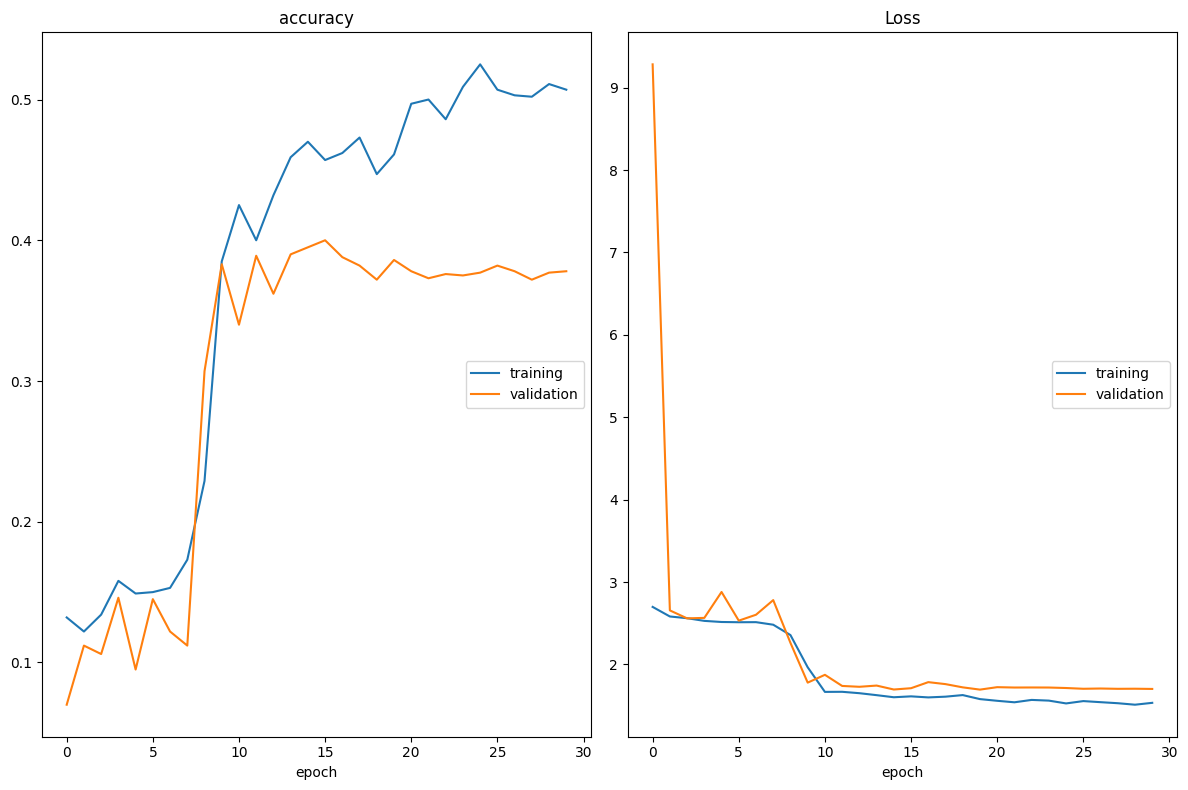

accuracy
	training         	 (min:    0.122, max:    0.525, cur:    0.507)
	validation       	 (min:    0.070, max:    0.400, cur:    0.378)
Loss
	training         	 (min:    1.511, max:    2.698, cur:    1.534)
	validation       	 (min:    1.695, max:    9.282, cur:    1.703)
Epoch 30/30: Train Loss = 1.5341, Train Acc = 0.5070, Val Loss = 1.7028, Val Acc = 0.3780


In [ ]:
model = train_model(model, optimizer, train_loader, val_loader, num_epochs, freeze_epochs)

### **5. Further Evaluating this model**

Let's evaluate the model again but now let's breakdown its performance by type of question. Report your results in this [spreadsheet](https://docs.google.com/spreadsheets/d/1Iyc6_QH07X0xxTGX_4H1tY1TS5Xqj3VltDPBr3PKyiQ/edit?usp=sharing):

In [ ]:
# --- Compute accuracy per question type on the validation set ---
model.eval()
type_correct = {}  # Dictionary to count correct predictions per type.
type_total = {}    # Dictionary to count total samples per type.

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        questions = batch["question"].to(device)
        answers = batch["answer"].to(device)
        q_types = batch["question_type"]  # List of question type strings for this batch

        logits = model(images, questions)  # (batch, num_answers)
        preds = torch.argmax(logits, dim=1)  # (batch,)

        # Loop over each sample in the batch.
        for i, qt in enumerate(q_types):
            if qt not in type_total:
                type_total[qt] = 0
                type_correct[qt] = 0
            type_total[qt] += 1
            if preds[i] == answers[i]:
                type_correct[qt] += 1

print("\nValidation Accuracy per Question Type:")
for qt in type_total:
    accuracy = type_correct[qt] / type_total[qt]
    print(f"  Question type '{qt}': Accuracy = {accuracy:.4f} ({type_correct[qt]}/{type_total[qt]})")


Validation Accuracy per Question Type:
  Question type 'count': Accuracy = 0.3375 (107/317)
  Question type 'extreme': Accuracy = 0.3444 (104/302)
  Question type 'unique': Accuracy = 0.5089 (171/336)
  Question type 'left_right': Accuracy = 0.3778 (17/45)


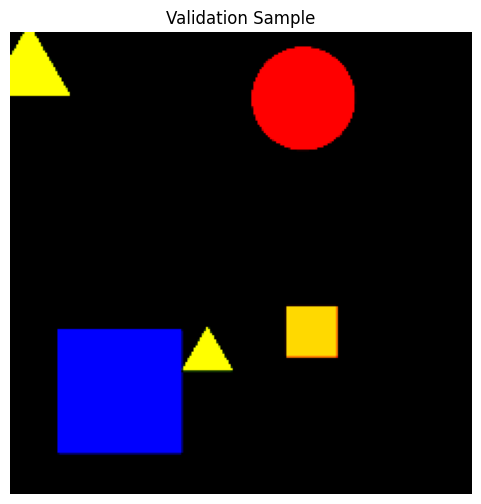

Original Question:
Which color represents the biggest triangle?

Ground Truth Answer:
yellow

Predicted Answer:
yellow


In [ ]:
# ============================================================
#  Display a Sample Prediction from Validation Set
# ============================================================

# Define the answer mapping (same as used in your dataset)
answer2idx = {
    "red": 0, "blue": 1, "green": 2, "yellow": 3, "purple": 4, "orange": 5,
    "circle": 6, "square": 7, "triangle": 8,
    "0": 9, "1": 10, "2": 11, "3": 12, "4": 13, "5": 14
}
idx2answer = {v: k for k, v in answer2idx.items()}

# --- Display a sample prediction from the validation set ---

# Pick a random index from the validation dataset
val_idx = random.randint(0, len(val_dataset) - 1)
sample = val_dataset[val_idx]  # sample from the custom Dataset; contains tokenized question, image, label
val_annotations = json.load(open(val_annotations_file))

# Retrieve the original annotation for the chosen sample
original_ann = val_annotations[val_idx]
original_question = original_ann["question"]
ground_truth_answer = str(original_ann["answer"])

# Prepare the sample for model prediction (add batch dimension)
model.eval()
image = sample["image"].unsqueeze(0).to(device)        # shape: (1, 3, H, W)
question = sample["question"].unsqueeze(0).to(device)    # shape: (1, max_question_len)
with torch.no_grad():
    logits = model(image, question)                      # shape: (1, num_answers)
    pred_idx = torch.argmax(logits, dim=1).item()
predicted_answer = idx2answer[pred_idx]

# Display the image
sample_img = image[0].cpu().permute(1, 2, 0).numpy()
plt.figure(figsize=(6,6))
plt.imshow(sample_img)
plt.axis("off")
plt.title("Validation Sample")
plt.show()

# Print the original question, ground truth answer, and predicted answer
print("Original Question:")
print(original_question)
print("\nGround Truth Answer:")
print(ground_truth_answer)
print("\nPredicted Answer:")
print(predicted_answer)

## **Assignment Questions**

#### **1. Random Guesser Accuracy [0.5pts]**
What is the accuracy of a model that takes a random guess to provide an answer and ignores the input question and input image? Show your calculation in the cell below.

In [ ]:
# We have 15 possible answers to each question, therefore, provided there's a
# uniform distribution of answers, the Random Guesser will be
# P(guess) = 1/15 = 0.0666

#### **2. Zero-knowledge Accuracy [0.5pts]**
What is the accuracy of a model that guesses but takes advantage of the probability distribution of answers in the training set. Show your calculation in the cell below.

In [ ]:
trainset.answer2idx

{'red': 0,
 'blue': 1,
 'green': 2,
 'yellow': 3,
 'purple': 4,
 'orange': 5,
 'circle': 6,
 'square': 7,
 'triangle': 8,
 '0': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '5': 14}

In [ ]:
trainset.answer2idx[str(trainset.annotations[0]['answer'])]

9

In [ ]:
# Your code or logic goes here.
counter = np.zeros(15)
for i in range(len(trainset)):
  counter[trainset.answer2idx[str(trainset.annotations[i]['answer'])]] +=1
counter

array([ 66.,  51.,  55.,  59.,  54.,  43.,  66., 125., 153., 115., 130.,
        61.,  15.,   6.,   1.])

In [ ]:
counter = np.zeros(15)
for i in range(len(valset)):
  counter[valset.answer2idx[str(valset.annotations[i]['answer'])]] +=1
counter

array([ 50.,  54.,  54.,  53.,  53.,  65.,  89., 134., 131., 108., 109.,
        75.,  20.,   5.,   0.])

In [ ]:
# weighted probability based on the distribution of the answers
# basically the sum of the squares of the frequencies above
# (66/1000)**2 + (51/1000)**2 + ... + (1/1000)**2 = 0.0957 = 9.57%

#### **3. Oracle-question Guesser Accuracy [1pt]**
What is the accuracy of a model that has a way of knowing exactly the type of question being asked but guesses randomly conditioned on this knowledge. Assume that the types of questions are equally distributed in the training and validation sets. Show your calculations in the cell below.

In [ ]:
# theres four types of questions, equally distributed, so 25% chance each
# the questions have 3, 6, 6, and 9 possible answers respectively
# therefore the answer is the added probability of all 4 terms
# 0.25(1/3 + 1/6 + 1/9 + 1/6) = 0.19444 = 19.44%

#### **4. Extra Data Generation [2pts]**

Train a better model by generating more training data. You are encouraged to use a coding assistant to generate more data that is as close as possible as the training data provided for the assignment. Include your prompts here and/or link to the coding assistant history. In any case, include here code for generating the extra data. Use up to 10x the amount of training images. You are required to improve your base model by at least 5% without changing anything in the model. Your results should be reported in this [spreadsheet](https://docs.google.com/spreadsheets/d/1mqy9p5HN4KK_LQIz2sGFR_eFezkcr53o-MBTtfSjzXE/edit?usp=sharing).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon
import json
import random
import os
import shutil

trainset_dir = 'ShapesQA_trainset'
augmented_data_dir = 'ShapesQA_augmented'
os.makedirs(augmented_data_dir, exist_ok=True)

for filename in os.listdir(trainset_dir):
    if filename.endswith('.png'):
        shutil.copy(os.path.join(trainset_dir, filename), os.path.join(augmented_data_dir, filename))

trainset_annotations_path = os.path.join(trainset_dir, 'annotation.json')
if os.path.exists(trainset_annotations_path):
    with open(trainset_annotations_path, 'r') as f:
        existing_annotations = json.load(f)
else:
    existing_annotations = []

def generate_synthetic_image(image_id):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_facecolor('black')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    shapes = ['circle', 'square', 'triangle']
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']

    num_shapes = 5
    placed_objects = []

    while num_shapes != 0:
        num_shapes -= 1
        shape = random.choice(shapes)
        color = random.choice(colors)
        size = random.uniform(0.11, 0.22)
        x = random.uniform(0.1, 0.9)
        y = random.uniform(0.1, 0.9)

        # Avoid overlap (simplified check)
        valid_position = True
        for obj in placed_objects:
            dist = np.sqrt((x - obj['x'])**2 + (y - obj['y'])**2)
            if dist < (size + obj['size']):
                valid_position = False
                num_shapes += 1
                break

        if not valid_position:
            continue

        # Draw shape
        if shape == 'circle':
            ax.add_patch(Circle((x, y), size/2, color=color))
        elif shape == 'square':
            ax.add_patch(Rectangle((x-size/2, y-size/2), size, size, color=color))
        elif shape == 'triangle':
            points = [(x, y+size/2), (x-size/2, y-size/2), (x+size/2, y-size/2)]
            ax.add_patch(Polygon(points, closed=True, color=color))

        placed_objects.append({
            'shape': shape,
            'color': color,
            'size': size,
            'x': x,
            'y': y
        })

    filename = f"synthetic_{image_id:04d}.png"
    full_path = os.path.join(augmented_data_dir, filename)
    plt.savefig(full_path, facecolor='black', bbox_inches='tight')
    plt.close()

    return filename, placed_objects

def generate_questions(filename, objects):
    questions = []

    # COUNT
    for color in ['red', 'blue', 'green', 'yellow', 'purple', 'orange']:
        for shape in ['circle', 'square', 'triangle']:
            count = sum(1 for obj in objects if obj['color'] == color and obj['shape'] == shape)
            # if count > 0:
            count_templates = [
                f"How many {color} {shape}s are there in the image?",
                f"Number of {color} {shape}s in the image?",
                f"Count the number of {color} {shape}s present in the picture.",
                f"What is the total count of {color} {shape}s present?",
            ]
            question = {
                "image": filename,
                "question": random.choice(count_templates),
                "answer": count,
                "question_type": "count"
            }
            if count == 0:
              rand = random.random()
              if rand < 0.2:
                questions.append(question)
            else:
              questions.append(question)
        for color in ['red', 'blue', 'green', 'yellow', 'purple', 'orange']:
            count = sum(1 for obj in objects if obj['color'] == color)
            # if count > 0:
            count_templates = [
                f"How many {color} objects are there in the image?",
                f"Number of {color} objects are in the image?",
                f"Count the number of {color} objects present in the picture.",
                f"What is the total count of {color} objects present?",
            ]
            question = {
                "image": filename,
                "question": random.choice(count_templates),
                "answer": count,
                "question_type": "count"
            }
            # if count == 0:
            rand = random.random()
            if rand < 0.08:
                questions.append(question)
            # else:
            #   questions.append(question)

    for shape in ['circle', 'square', 'triangle']:
        count = sum(1 for obj in objects if obj['shape'] == shape)
        # if count > 0:
        count_templates = [
            f"How many {shape}s are there in the image?",
            f"Number of {shape}s in the image?",
            f"Count the number of {shape}s present in the picture.",
            f"What is the total count of {shape}s present?",
        ]
        question = {
            "image": filename,
            "question": random.choice(count_templates),
            "answer": count,
            "question_type": "count"
        }
        # if count == 0:
        rand = random.random()
        if rand < 0.08:
            questions.append(question)
        # else:
        #   questions.append(question)

    # LEFT RIGHT
    for i, obj1 in enumerate(objects):
        for j, obj2 in enumerate(objects):
            if i != j:
                # Horizontal relationships
                if abs(obj1['y'] - obj2['y']) < 0.18:  # Objects roughly on same horizontal line
                    side = random.choice(['left', 'right'])
                    if obj1['x'] < obj2['x']:
                        position_templates = [
                            (
                            [
                              f"What shape is directly to the right of the {obj1['color']} {obj1['shape']}?",
                              f"Determine the shape of the object immediately to the right of the {obj1['color']} {obj1['shape']}.",
                              f"Identify the shape that is positioned next to the {obj1['color']} {obj1['shape']} on its right side."
                            ],
                              obj2['shape']
                            ),
                            (
                              [
                                  f"Identify the color of the object immediately to the right of the {obj1['color']} {obj1['shape']}.",
                                  f"What is the color of the shape that is directly to the right of the {obj1['color']} {obj1['shape']}?",
                                  f"Determine the color of the shape positioned next to the {obj1['color']} {obj1['shape']} on its right side."
                              ],
                                obj2['color']
                            )
                        ]

                        if side == 'left':
                            question_list, answer = random.choice(position_templates)
                            question_text = random.choice(question_list)

                            questions.append({
                                "image": filename,
                                "question": question_text,
                                "answer": answer,
                                "question_type": "left_right"
                            })

                    elif obj1['x'] > obj2['x']:
                        position_templates = [
                            (
                            [
                              f"What shape is directly to the left of the {obj1['color']} {obj1['shape']}?",
                              f"Determine the shape of the object immediately to the left of the {obj1['color']} {obj1['shape']}.",
                              f"Identify the shape that is positioned next to the {obj1['color']} {obj1['shape']} on its left side.",
                            ],
                              obj2['shape']
                            ),
                            (
                              [
                                f"Identify the color of the object immediately to the left of the {obj1['color']} {obj1['shape']}.",
                                f"What is the color of the shape that is directly to the left of the {obj1['color']} {obj1['shape']}?",
                                f"Determine the color of the shape positioned next to the {obj1['color']} {obj1['shape']} on its left side."
                              ],
                              obj2['color']
                            )
                        ]

                        if side == 'right':
                            question_list, answer = random.choice(position_templates)
                            question_text = random.choice(question_list)

                            questions.append({
                                "image": filename,
                                "question": question_text,
                                "answer": answer,
                                "question_type": "left_right"
                            })

    # UNIQUE
    unique_combos = {}
    for obj in objects:
        key = (obj['color'], obj['shape'])
        if key in unique_combos:
            unique_combos[key] += 1
        else:
            unique_combos[key] = 1

    for (color, shape), count in unique_combos.items():
        if count == 1:
            unique_templates = [
                f"What shape is the {color} object?",
                f"Determine the shape of the {color} object.",
                f"Can you tell me the shape of the {color} object?",
                f"Which shape does the {color} object have in the picture?",
                f"What shape is the {color} object in the image?",
                f"What is the shape of the single {color} object?",
                f"Identify the shape of the {color} figure in the image.",
            ]
            questions.append({
                "image": filename,
                "question": random.choice(unique_templates),
                "answer": shape,
                "question_type": "unique"
            })

    # EXTREME
    for shape in ['circle', 'square', 'triangle']:
        shape_objects = [obj for obj in objects if obj['shape'] == shape]
        if len(shape_objects) > 1:
            smallest = min(shape_objects, key=lambda x: x['size'])
            largest = max(shape_objects, key=lambda x: x['size'])

            size_templates_smallest = [
                f"In the image, what is the color of the smallest {shape}?",
                f"Which color represents the smallest {shape}?",
                f"Identify the color of the smallest {shape}.",
                f"What color is the smallest {shape}?",
                f"What color is the smallest {shape} in the picture?"
            ]

            size_templates_largest = [
                f"In the image, what is the color of the largest {shape}?",
                f"What color is the biggest {shape} in the image?",
                f"Which color represents the biggest {shape}?",
                f"Identify the color of the largest {shape} in the picture.",
            ]

            questions.append({
                "image": filename,
                "question": random.choice(size_templates_smallest),
                "answer": smallest['color'],
                "question_type": "extreme"
            })

            questions.append({
                "image": filename,
                "question": random.choice(size_templates_largest),
                "answer": largest['color'],
                "question_type": "extreme"
            })

    # Randomly select a subset of questions to avoid repetition
    if len(questions) > 0:
        return random.sample(questions, min(5, len(questions)))
    return []

def generate_dataset(num_images=100):
    all_questions = []

    for i in range(num_images):
        filename, objects = generate_synthetic_image(i)
        questions = generate_questions(filename, objects)
        all_questions.extend(questions)

    # Merge with existing annotations
    all_questions.extend(existing_annotations)

    # Save combined dataset
    json_path = os.path.join(augmented_data_dir, 'annotations.json')
    with open(json_path, 'w') as f:
        json.dump(all_questions, f, indent=2)

    print(f"Generated dataset with {len(all_questions)} question-answer pairs.")
    print(f"Files saved to: {os.path.abspath(augmented_data_dir)}")

generate_dataset(1800)


Generated dataset with 9000 question-answer pairs.
Files saved to: /content/ShapesQA_augmented


In [ ]:
# ============================================================
# Create Vocabulary for the tokenizer.
# ============================================================
train_annotations_file = "ShapesQA_augmented/annotations.json"
val_annotations_file   = "ShapesQA_valset/annotations.json"
train_image_dir = "ShapesQA_augmented"
val_image_dir   = "ShapesQA_valset"

with open(train_annotations_file, "r") as f:
    train_annotations = json.load(f)
with open(val_annotations_file, "r") as f:
    val_annotations = json.load(f)

all_train_questions = [ann["question"] for ann in train_annotations]
vocab = build_vocab(all_train_questions, min_freq=1)
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

# ============================================================
# Create Datasets and DataLoaders
# ============================================================
# You are required to make some changes here as specified earlier.
train_image_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ShapesQADataset(annotations=train_annotations_file,
                           image_dir=train_image_dir,
                           vocab=vocab,
                           transform=train_image_transform,
                           max_question_len=20)
val_dataset = ShapesQADataset(annotations=val_annotations_file,
                         image_dir=val_image_dir,
                         vocab=vocab,
                         transform=image_transform,
                         max_question_len=20)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# ============================================================
# Initialize Model, Loss, and Optimizer
# ============================================================

num_answers = 15  # e.g., 6 colors + 3 shapes + 6 count answers
model = VQAModel(vocab_size, num_answers=num_answers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)

# Feel free to change this to whatever you consider most appropriate.
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

# ============================================================
# Training and Validation Loops with Livelossplot
# ============================================================
# NOTE: Feel free to modify any of the code below. This is just what worked
# for me with the model I created.

from livelossplot import PlotLosses

liveplot = PlotLosses()
# Feel free to change any hyperparameters here.
num_epochs = 30  # Total epochs

# Define the epoch at which to unfreeze the CNN branch.
freeze_epochs = 15 # Freeze for the first 18 epochs, unfreeze for the last 2 epochs

Vocabulary size: 71


In [ ]:
def train_model(model, optimizer, train_loader, val_loader, num_epochs, freeze_epochs, scheduler):

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Unfreeze CNN parameters at the start of epoch freeze_epochs.
        if epoch == freeze_epochs:
            print("Unfreezing CNN parameters for fine-tuning...")
            for param in model.cnn.parameters():
                param.requires_grad = True
            # Update the optimizer to include the newly unfrozen CNN parameters.
            # aca le cambie el lr de 1e-4 a 1e-3
            cur_lr = optimizer.param_groups[0]['lr']
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=cur_lr)

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            images = batch["image"].to(device)
            questions = batch["question"].to(device)
            answers = batch["answer"].to(device)

            optimizer.zero_grad()
            logits = model(images, questions)
            loss = criterion(logits, answers)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == answers).sum().item()
            total_train += answers.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                questions = batch["question"].to(device)
                answers = batch["answer"].to(device)

                logits = model(images, questions)
                loss = criterion(logits, answers)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == answers).sum().item()
                total_val += answers.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

        liveplot.update({
            'loss': avg_train_loss,
            'accuracy': train_acc,
            'val_loss': avg_val_loss,
            'val_accuracy': val_acc,
        })
        liveplot.send()

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
            f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")
        scheduler.step()

    model.load_state_dict(best_model_state)
    return model

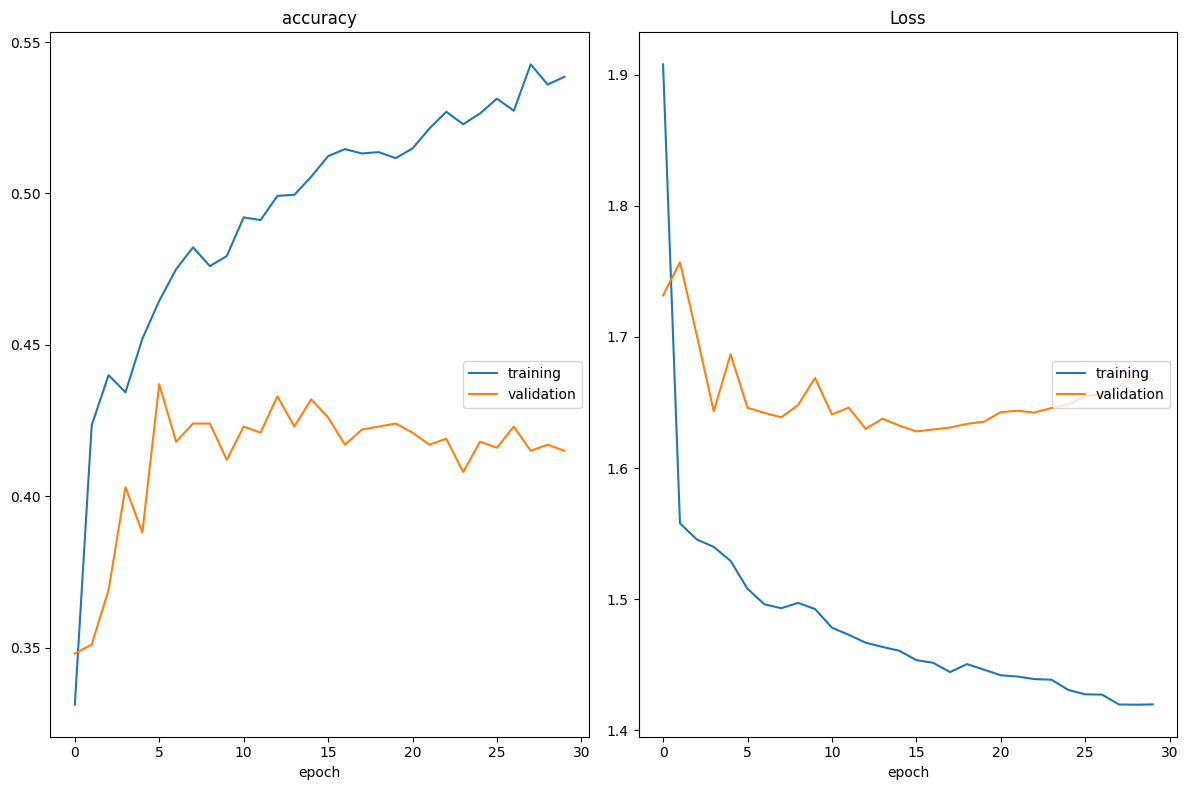

accuracy
	training         	 (min:    0.331, max:    0.543, cur:    0.539)
	validation       	 (min:    0.348, max:    0.437, cur:    0.415)
Loss
	training         	 (min:    1.420, max:    1.908, cur:    1.420)
	validation       	 (min:    1.628, max:    1.757, cur:    1.667)
Epoch 30/30: Train Loss = 1.4198, Train Acc = 0.5386, Val Loss = 1.6674, Val Acc = 0.4150


In [ ]:
model = train_model(model, optimizer, train_loader, val_loader, num_epochs, freeze_epochs, scheduler)

Training Loop

#### **5. Revisiting Assignment 1: Zero-shot Image Classification with CLIP [3pts]**



In January 2021, OpenAI published a research paper named CLIP ([Contrastive Language-Image Pretraining](https://arxiv.org/abs/2103.00020)) https://openai.com/blog/clip/. This model was trained to maximize the dot product between vector representations of text and images that have a direct correspondence and minimize their dot product when they do not correspond. One key property of this model is that it can be used to build zero-shot classifier. Since the model was trained on a large number of images and text from the web, this model knows about a lot of categories of things. Your goal in this section is to obtain the best results using the illustrated approach in this figure for the scene classification problem of Assignment 1 (SUN20). Please enter the best classification accuracy in the [leaderboard](https://docs.google.com/spreadsheets/d/1mKXal0_abpq3cyAisfjI1xnWxNfIsYxvej5GPcrDf5M/edit?usp=sharing) here using CLIP. [To get full points obtain more than 94% accuracy and your code should run in less than 60 seconds]. Feel free to use other versions of CLIP, e.g. MetaCLIP (https://github.com/facebookresearch/MetaCLIP), OpenCLIP (https://github.com/mlfoundations/open_clip), EVA-CLIP (https://github.com/baaivision/EVA).

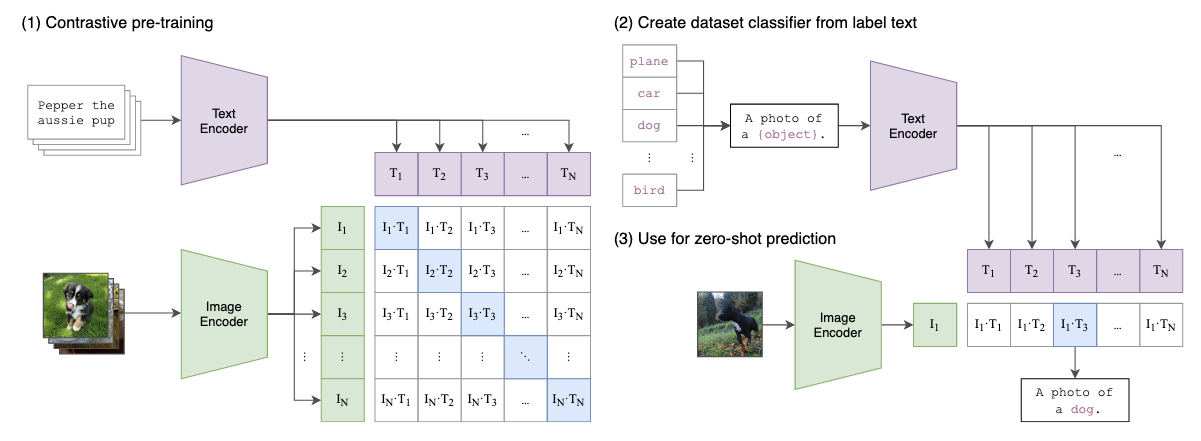

In [ ]:
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
!tar xf SUN20-train-sm.tar.gz
!tar xf SUN20-val.tar.gz

File ‘SUN20-train-sm.tar.gz’ already there; not retrieving.

File ‘SUN20-val.tar.gz’ already there; not retrieving.



In [ ]:
import os, json, pickle, random
import torch.utils.data
from PIL import Image

# Simple implementation of a custom data loading class for our SUN20 dataset.
class SUN20(torch.utils.data.Dataset):

  # Initialize the class e.g. load files, preprocess, etc.
  def __init__(self, split = 'train', transform = None):

    # These are the 20 categories selected.
    self.categories = open('SUN20/' + split + '/ClassName.txt').read().split('\n')[:-1]
    self.categories = sorted(self.categories)
    self.category2index = {category: idx for (idx, category) in enumerate(self.categories)}
    self.transform = transform

    # Compile a list of images and corresponding labels.
    self.imagepaths = []
    self.labels = []
    for category in self.categories:
      category_directory = 'SUN20/' + split + category
      category_imagenames = os.listdir(category_directory)
      self.imagepaths += [os.path.join(category_directory, imagename)
                          for imagename in category_imagenames]
      self.labels += [self.category2index[category]] * len(category_imagenames)

    # Sort imagepaths alphabetically and labels accordingly.
    sorted_pairs = sorted(zip(self.imagepaths, self.labels), key = lambda x: x[0])
    self.imagepaths, self.labels = zip(*sorted_pairs)


  # Return a sample (x, y) as a tuple e.g. (image, label)
  def __getitem__(self, index):
    image = Image.open(self.imagepaths[index]).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, self.labels[index]

  # Return the total number of samples.
  def __len__(self):
    return len(self.imagepaths)

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_7my56rk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_7my56rk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import clip
from tqdm import tqdm
import numpy as np
from torchvision import transforms

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)

class SUN20CLIP(SUN20):
    def __init__(self, split='train'):
        super().__init__(split=split, transform=preprocess)

        self.clean_labels = {
            '/a/arch': 'an arch',
            '/b/bathroom': 'a bathroom',
            '/b/butte': 'a butte',
            '/d/dentists_office': "a dentist's office",
            '/h/hot_spring': 'a hot spring',
            '/j/jacuzzi/indoor': 'an indoor jacuzzi',
            '/l/laundromat': 'a laundromat',
            '/l/lecture_room': 'a lecture room',
            '/l/library/indoor': 'an indoor library',
            '/l/lighthouse': 'a lighthouse',
            '/l/living_room': 'a living room',
            '/m/mansion': 'a mansion',
            '/m/marsh': 'a marsh',
            '/m/mountain': 'a mountain',
            '/s/sauna': 'a sauna',
            '/s/shower': 'a shower',
            '/s/skyscraper': 'a skyscraper',
            '/t/tower': 'a tower',
            '/t/tree_house': 'a tree house',
            '/v/volcano': 'a volcano'
        }

        self.text_inputs = []
        for category in self.categories:
            clean_category = self.clean_labels[category]
            templates = [
                f"a photo of {clean_category}",
                f"a scenic view of {clean_category}",
                f"a photograph of {clean_category}",
                f"an outdoor scene of {clean_category}",
                f"a landscape showing {clean_category}",
                f"{clean_category} scenery",
                f"{clean_category} landscape",
                f"{clean_category} scene",
                f"a view of {clean_category}",
                f"this is definitely {clean_category}",
                f"seeing {clean_category} is breathtaking",
                f"we are lucky to be in the presence of {clean_category}",
                f"{clean_category} environment",
                f"{clean_category} location",
                f"this is {clean_category}",
                f"this looks like {clean_category}",
                f"this is definitely {clean_category}",
            ]
            self.text_inputs.extend(templates)

        # Tokenize all text prompts
        self.text_tokens = clip.tokenize(self.text_inputs).to(device)

        # Pre-compute text features
        with torch.no_grad():
            self.text_features = model.encode_text(self.text_tokens)
            self.text_features = self.text_features.float()

        # Reshape text features to group by category
        num_templates = len(templates)
        self.text_features = self.text_features.reshape(len(self.categories), num_templates, -1)

    def __getitem__(self, index):
        image = Image.open(self.imagepaths[index]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[index]  # Use original labels for indexing

def evaluate(model, dataset, batch_size=32):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            # Get image features
            image_features = model.encode_image(images)
            image_features = image_features.float()

            # Calculate similarity with all text prompts
            similarity = torch.zeros((len(images), len(dataset.categories)), device=device)

            # For each category, compute average similarity across templates
            for i in range(len(dataset.categories)):
                category_text_features = dataset.text_features[i]
                category_similarity = (image_features @ category_text_features.T).mean(dim=1)
                similarity[:, i] = category_similarity

            # Get predictions
            predictions = similarity.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += len(labels)

    accuracy = 100 * correct / total
    return accuracy

val_dataset = SUN20CLIP('val')

val_accuracy = evaluate(model, val_dataset)
print(f"Validation Accuracy: {val_accuracy:.2f}%")

100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

Validation Accuracy: 95.30%


#### **6. Use InternVL2.5 to solve the ShapesQA problem [2pts -- extra]**

InternVL2.5 is a powerful family of Vision-Language-Models (VLMs). They are able to take input images and text and answer arbitrary questions. You can find how to use them here https://internvl.github.io/blog/2024-12-05-InternVL-2.5/. You can read more technical details about this model here https://arxiv.org/abs/2412.05271. Report the overall accuracy on the ShapesQA validation set using a  model from this family of models. Whichever model you can fit in the memory on Google Colab's GPU instances. Note: Finetuning or any type of training is not needed or allowed for this question. The model has to be used as-is. You only need to prompt it appropriately and compute the accuracy based on its answers.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
path = "OpenGVLab/InternVL2_5-4B"
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval().cuda()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.63k [00:00<?, ?B/s]

configuration_internvl_chat.py:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2-4B:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


configuration_intern_vit.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2-4B:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2-4B:
- configuration_internvl_chat.py
- configuration_phi3.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internvl_chat.py:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

conversation.py:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2-4B:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_intern_vit.py:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2-4B:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2-4B:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2-4B:
- modeling_internvl_chat.py
- conversation.py
- modeling_intern_vit.py
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


FlashAttention2 is not installed.


model.safetensors.index.json:   0%|          | 0.00/48.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.34G [00:00<?, ?B/s]

Phi3ForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

In [ ]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("OpenGVLab/InternVL2_5-4B")

# Test on a single example
idx = 0  # You can change this to test different examples
sample = valset[idx]

# print("\nSample details:")
# print(f"Image shape: {sample['image'].shape}")
# print(f"Question: {sample['question']}")
# print(f"Answer label (index): {sample['answer'].item()}")
# print(f"True answer (text): {valset.idx2answer[sample['answer'].item()]}")
# print(f"Question type: {sample['question_type']}")

pixel_values = load_image('./ShapesQA_trainset/synthetic_0000.png', max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=True)

question = '<image>\nHow many orange circles in the image?'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

# response, history = model.chat(tokenizer, None, sample['question'], generation_config, history=None, return_history=True)
# print(f'User: {question}\nAssistant: {response}')

tokenizer_config.json:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/469 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


User: <image>
How many orange circles in the image?
Assistant: There is one orange circle in the image.


In [ ]:
def test_single_example(idx):
    sample = valset[idx]
    true_answer = valset.idx2answer[sample['answer'].item()]
    question_text = sample['question']

    # Get the image path from the annotations
    ann = valset.annotations[idx]
    image_path = os.path.join(valset.image_dir, ann["image"])

    # Prepare image
    pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()

    # Format prompt to constrain answers
    prompt = f"<image>\n{question_text}\nChoose one answer from the following options: red, blue, green, yellow, purple, orange, circle, square, triangle, 0, 1, 2, 3, 4, 5.\nAnswer with only one word from the options above."

    # Generate response
    generation_config = dict(max_new_tokens=10, do_sample=False, temperature=0.1)
    response = model.chat(tokenizer, pixel_values, prompt, generation_config)

    # Extract answer (just the first word)
    predicted_answer = response.split()[0].strip().lower()

    # Check if answer is in our allowed set
    if predicted_answer not in valset.answer2idx:
        print(f"Warning: Model generated answer '{predicted_answer}' which is not in the allowed set")
        # Try to extract a valid answer from the response
        for word in response.lower().split():
            if word in valset.answer2idx:
                predicted_answer = word
                print(f"Extracted valid answer: {predicted_answer}")
                break

    is_correct = (predicted_answer == true_answer)

    print(f"\nQuestion: {question_text}")
    print(f"True answer: {true_answer}")
    print(f"Model response: {response}")
    print(f"Extracted answer: {predicted_answer}")
    print(f"Correct: {is_correct}")

    return {
        'question': question_text,
        'true_answer': true_answer,
        'predicted_answer': predicted_answer,
        'is_correct': is_correct,
        'full_response': response
    }

# Test on a single example
print("\nTesting a single example...")
result = test_single_example(4)


Testing a single example...

Question: Identify the color of the largest triangle in the picture.
True answer: red
Model response: red
Extracted answer: red
Correct: True


In [ ]:
def evaluate_model(valset, model, tokenizer, num_samples=None, start_idx=0):
    # Statistics
    correct = 0
    total = 0
    correct_by_type = {}
    total_by_type = {}
    results = []

    # Use all samples or a subset
    end_idx = min(start_idx + num_samples, len(valset)) if num_samples else len(valset)
    samples = range(start_idx, end_idx)

    for idx in tqdm(samples):
        # Get sample data
        sample = valset[idx]
        true_answer = valset.idx2answer[sample['answer'].item()]
        question_text = sample['question']
        question_type = sample['question_type']

        # Get image path
        ann = valset.annotations[idx]
        image_path = os.path.join(valset.image_dir, ann["image"])

        # Process image
        try:
            pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()

            # Format prompt to constrain answers
            prompt = f"<image>\n{question_text}\nChoose one answer from the following options: red, blue, green, yellow, purple, orange, circle, square, triangle, 0, 1, 2, 3, 4, 5.\nAnswer with only one word from the options above."

            # Generate response
            generation_config = dict(max_new_tokens=10, do_sample=False, temperature=0.1)
            response = model.chat(tokenizer, pixel_values, prompt, generation_config)

            # Extract answer (first word)
            predicted_answer = response.split()[0].strip().lower()

            # Check if answer is in our allowed set
            if predicted_answer not in valset.answer2idx:
                # Try to extract a valid answer from the response
                valid_answer_found = False
                for word in response.lower().split():
                    if word in valset.answer2idx:
                        predicted_answer = word
                        valid_answer_found = True
                        break

                if not valid_answer_found:
                    print(f"Warning: No valid answer found in response: '{response}'")
                    predicted_answer = "unknown"  # Mark as unknown for logging

            # Check if correct
            is_correct = (predicted_answer == true_answer)

            # Update statistics
            if is_correct:
                correct += 1
            total += 1

            # Update type-specific statistics
            if question_type not in correct_by_type:
                correct_by_type[question_type] = 0
                total_by_type[question_type] = 0

            if is_correct:
                correct_by_type[question_type] += 1
            total_by_type[question_type] += 1

            # Store result
            result = {
                'idx': idx,
                'question': question_text,
                'question_type': question_type,
                'true_answer': true_answer,
                'predicted_answer': predicted_answer,
                'is_correct': is_correct,
                'full_response': response
            }
            results.append(result)

            # Print progress and current accuracy
            if (idx - start_idx + 1) % 10 == 0:
                print(f"Progress: {idx-start_idx+1}/{end_idx-start_idx}, Current accuracy: {correct/total:.4f}")

        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            continue

    # Calculate overall accuracy
    accuracy = correct / total if total > 0 else 0

    # Calculate accuracy by question type
    accuracy_by_type = {}
    for qtype in total_by_type:
        accuracy_by_type[qtype] = correct_by_type[qtype] / total_by_type[qtype] if total_by_type[qtype] > 0 else 0

    return {
        'accuracy': accuracy,
        'correct': correct,
        'total': total,
        'accuracy_by_type': accuracy_by_type,
        'results': results
    }

# Main script execution
if __name__ == "__main__":
    print("Loading model and tokenizer...")
    # Initialize model
    model = AutoModel.from_pretrained(
        "OpenGVLab/InternVL2-4B",
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        use_flash_attn=True,
        trust_remote_code=True
    ).eval().cuda()

    tokenizer = AutoTokenizer.from_pretrained("OpenGVLab/InternVL2-4B")

    # Create dataset
    print("Creating validation dataset...")
    valset = ShapesQADataset(
        annotations="ShapesQA_valset/annotations.json",
        vocab=None,
        image_dir="ShapesQA_valset"
    )
    print(f"Validation set size: {len(valset)}")

    # Run evaluation
    print("\nStarting evaluation...")

    # Optional: configure to run in chunks to avoid memory issues
    chunk_size = 100  # Adjust as needed
    total_samples = len(valset)

    # For testing, we can start with a small number of samples
    # Set test_run to False for full evaluation
    test_run = False
    if test_run:
        eval_results = evaluate_model(valset, model, tokenizer, num_samples=10, start_idx=0)
        print(f"\nTest run results:")
        print(f"Overall accuracy: {eval_results['accuracy']:.4f} ({eval_results['correct']}/{eval_results['total']})")
    else:
        # Initialize aggregate results
        all_results = []
        total_correct = 0
        total_samples_processed = 0

        # Process in chunks
        for start_idx in range(0, total_samples, chunk_size):
            print(f"\nProcessing samples {start_idx} to {min(start_idx + chunk_size, total_samples)}...")

            eval_results = evaluate_model(
                valset, model, tokenizer,
                num_samples=chunk_size,
                start_idx=start_idx
            )

            # Aggregate results
            all_results.extend(eval_results['results'])
            total_correct += eval_results['correct']
            total_samples_processed += eval_results['total']

            # Print chunk results
            print(f"Chunk accuracy: {eval_results['accuracy']:.4f}")
            print(f"Cumulative accuracy: {total_correct/total_samples_processed:.4f}")

            # Save intermediate results to avoid losing progress
            with open(f'results_chunk_{start_idx}_{min(start_idx + chunk_size, total_samples)}.json', 'w') as f:
                json.dump(eval_results, f)

        # Calculate overall accuracy
        final_accuracy = total_correct / total_samples_processed if total_samples_processed > 0 else 0

        # Print final results
        print("\n=== FINAL EVALUATION RESULTS ===")
        print(f"Overall accuracy: {final_accuracy:.4f} ({total_correct}/{total_samples_processed})")

        # Save all results
        with open('final_results.json', 'w') as f:
            json.dump({
                'accuracy': final_accuracy,
                'correct': total_correct,
                'total': total_samples_processed,
                'results': all_results
            }, f)

        print("Evaluation complete. Results saved to 'final_results.json'")

Loading model and tokenizer...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 14.12 MiB is free. Process 2582 has 14.72 GiB memory in use. Of the allocated memory 14.58 GiB is allocated by PyTorch, and 45.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)